# Supervised Learning

- Regression (discussed last week)
- $k$ nearest neighbours
- Decision trees

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## $k$ nearest neighbours (KNN) model

(array([[1, 2],
        [3, 5],
        [4, 3]]),
 array([0, 1, 1]))

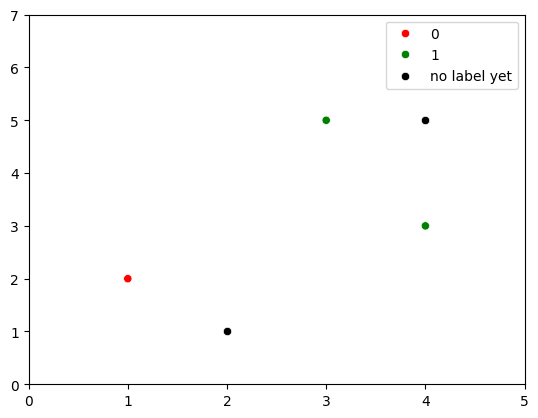

In [2]:
y = np.array([0, 1, 1])
x = np.array([
    [1, 2],
    [3, 5],
    [4, 3]
])

# test set
xt = np.array([[2, 1], [4, 5]])

plt.xlim(0, 5)
plt.ylim(0, 7)
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, palette=['r', 'g'])
sns.scatterplot(x=xt[:, 0], y=xt[:, 1], c='black', label='no label yet')

x, y

We want to find the probability $p(C = \text{red} \;|\; x)$

- determine value for $k$
- KNN is nonparametric, so entire dataset is needed to make prediction
- compute pairwise absolute distances between training set $X_{\text{train}}$ and test set $X_{\text{test}}$
- sort and use indices to collect corresponding $y$ values
- calculate probability of each $x \in X_{\text{test}}$ belonging to each class $C_i$. 

In [3]:
# look at 2-nearest neighbours
k=2

In [10]:
y[..., None], y

(array([[0],
        [1],
        [1]]),
 array([0, 1, 1]))

In [21]:
# broadcast (3,) y labels to (3, 2) 
y_mat = np.broadcast_to(y[..., None], shape=(x.shape[0], xt.shape[0]))

y_mat

array([[0, 0],
       [1, 1],
       [1, 1]])

In [22]:
xt[..., None], x[..., None].T

(array([[[2],
         [1]],
 
        [[4],
         [5]]]),
 array([[[1, 3, 4],
         [2, 5, 3]]]))

In [23]:
# (2, 2, 1) xt - (1, 2, 3) x.T = (2, 2, 3)
x_test_minus_x = xt[..., None]-x[..., None].T

x_test_minus_x

array([[[ 1, -1, -2],
        [-1, -4, -2]],

       [[ 3,  1,  0],
        [ 3,  0,  2]]])

In [24]:
# transpose second and third axes: (2, 2, 3) -> (2, 3, 2)
x_test_minus_x_T = np.transpose(x_test_minus_x, axes=(0, 2, 1))

x_test_minus_x_T

array([[[ 1, -1],
        [-1, -4],
        [-2, -2]],

       [[ 3,  3],
        [ 1,  0],
        [ 0,  2]]])

In [25]:
# sum over axis 2: (2, 3, 2) -> (2, 3)
# transpose: (2, 3) -> (3, 2) same dims as y_mat
abs_diff = np.sum(np.abs(x_test_minus_x_T), axis=2).T

abs_diff

array([[2, 6],
       [5, 1],
       [4, 2]])

In [26]:
i = abs_diff.argsort(axis=0)
i

array([[0, 1],
       [2, 2],
       [1, 0]])

In [27]:
# sort y labels based on absolute differences (nearest neighbours)
y_mat_sorted = np.take_along_axis(y_mat, i, axis=0)
y_mat_sorted

array([[0, 1],
       [1, 1],
       [1, 0]])

In [28]:
y_mat_sorted_kn = y_mat_sorted[:k, :] # take only the k nearest neighbours
y_mat_sorted_kn

array([[0, 1],
       [1, 1]])

In [29]:
classes = np.unique(y)
# from the k nearest, sum all that have the same label and store in vector
ki = (y_mat_sorted_kn == classes.reshape(classes.shape[0], 1, 1)).sum(axis=1) 

ki

array([[1, 0],
       [1, 2]])

In [30]:
# P(C_i | x)
p_ci_x = ki/k
p_ci_df = pd.DataFrame(p_ci_x/ p_ci_x.sum(axis=1)[..., None], columns=['p(C_0)', 'p(C_1)'])
p_ci_df

,p(C_0),p(C_1)
0,1.000000,0.000000
1,0.333333,0.666667


#### 3 class KNN classifier

<Axes: >

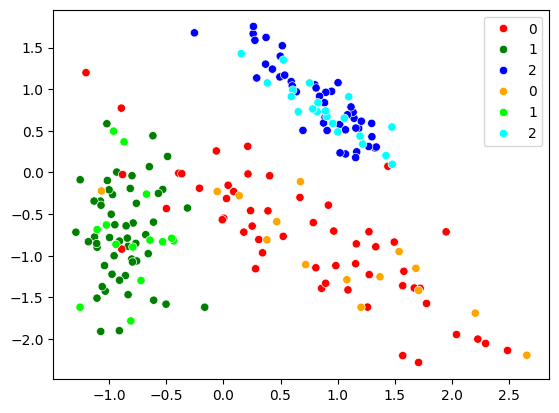

In [34]:
from sklearn.datasets import make_classification

X, Y = make_classification(
    n_samples=200, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=3,
    n_clusters_per_class=1,
    class_sep=1.2
)

X = (X - X.mean())/X.std()

X_test = X[:50, :]
Y_test = Y[:50]
X = X[50:, :]
Y = Y[50:]

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y, palette=['r', 'g', 'b'])
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=Y_test, palette=['orange', 'lime', 'cyan'])

In [35]:
def knn_estimator(x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, k=3):
    
    y_mat = np.broadcast_to(y_train[..., None], shape=(x_train.shape[0], x_test.shape[0]))

    abs_diff = np.sum(np.abs(np.transpose(x_test[..., None]-x_train[..., None].T, axes=(0, 2, 1))), axis=2).T
    i = abs_diff.argsort(axis=0)

    y_mat_sorted = np.take_along_axis(y_mat, i, axis=0)
    y_mat_sorted_kn = y_mat_sorted[:k, :]

    classes = np.unique(y_train)
    ki = (y_mat_sorted_kn == classes.reshape(classes.shape[0], 1, 1)).sum(axis=1)

    return ki/k

In [36]:
X_test[0]

array([ 0.38054695, -0.8085813 ])

In [37]:
y_pred = knn_estimator(X, Y, X_test[None, 0], k=3)
y_pred

array([[1.],
       [0.],
       [0.]])

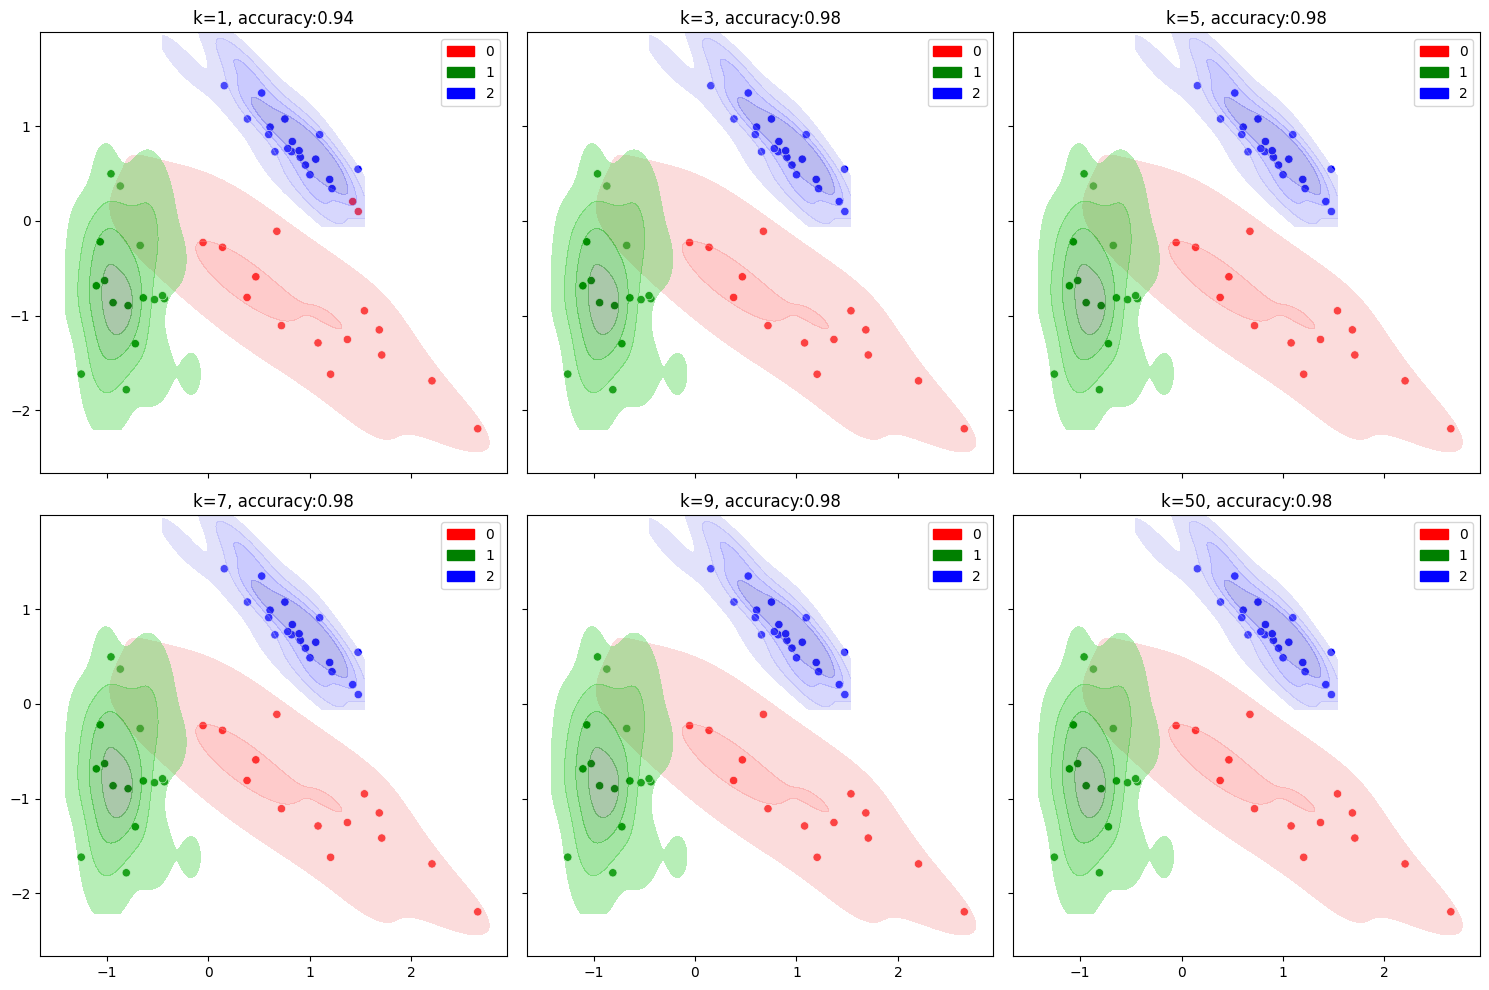

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
axes = axes.flatten()

ks = [1, 3, 5, 7, 9, 50]
for i, k in enumerate(ks):
    
    guesses = knn_estimator(X, Y, X_test, k)
    y_pred = guesses.argmax(axis=0)
    acc = np.sum(y_pred == Y_test)/Y_test.shape[0]
    
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, palette=['r', 'g', 'b'], ax=axes[i])
    sns.kdeplot(x=X[:, 0], y=X[:, 1], levels=5, hue=Y, palette=['r', 'g', 'b'], fill=True, alpha=0.4, cut=1, ax=axes[i])
    axes[i].set_title(f"{k=}, accuracy:{float(acc)}")

plt.tight_layout()

### Sklearn KNN 

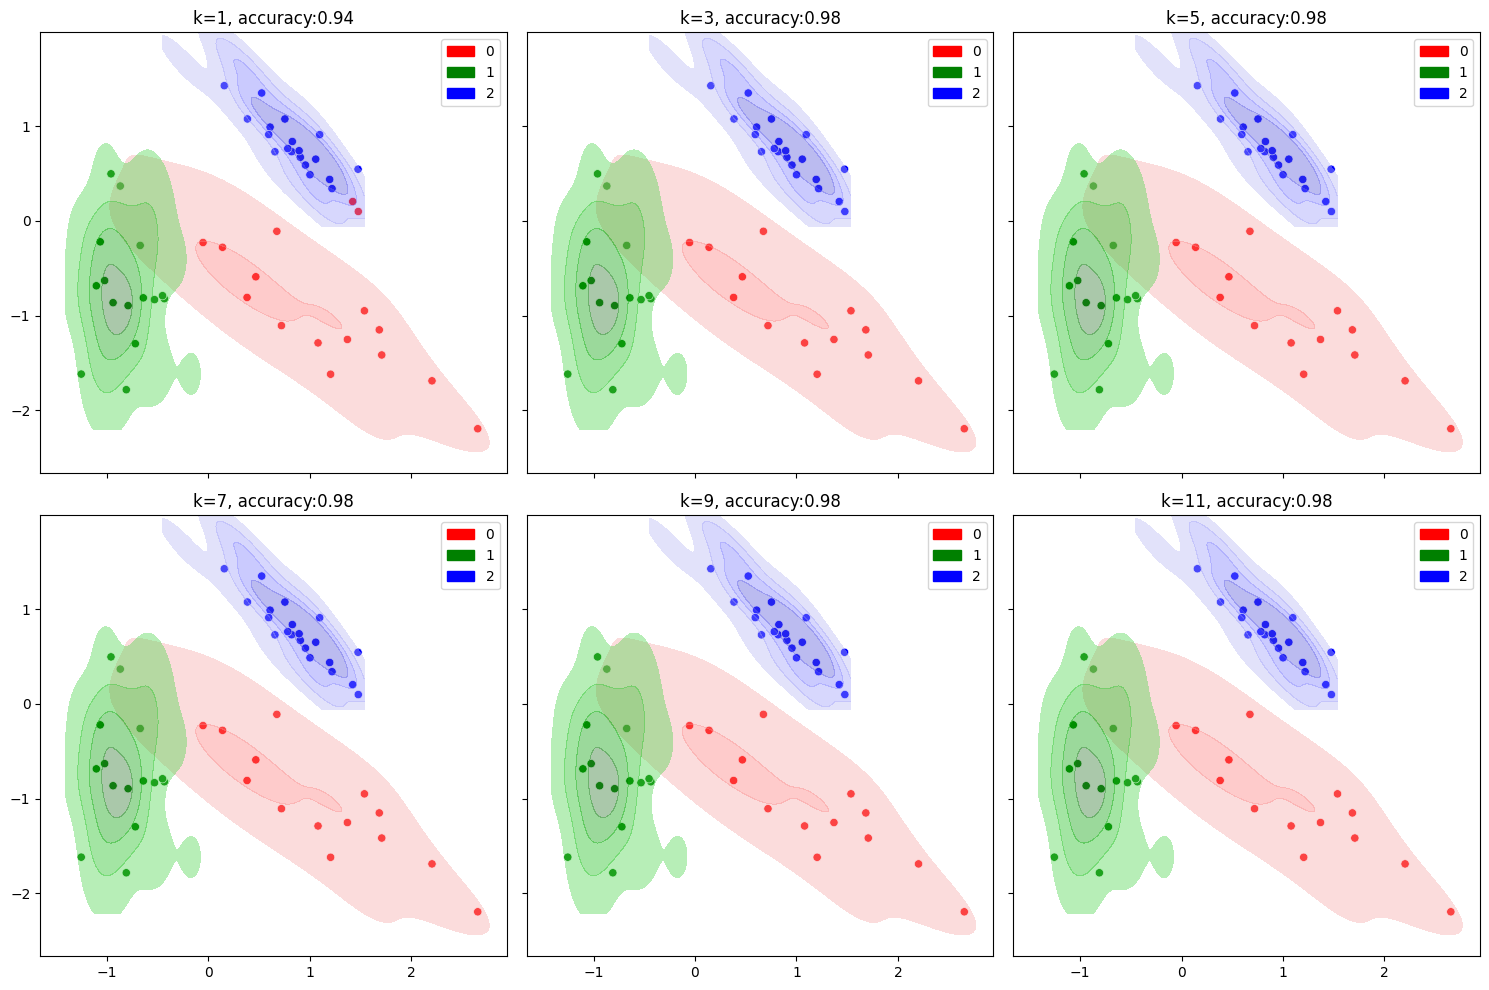

In [40]:
from sklearn.neighbors import KNeighborsClassifier

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
axes = axes.flatten()

ks = [1, 3, 5, 7, 9, 11]
for i, k in enumerate(ks):
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, Y)

    y_pred = knn.predict(X_test)

    acc = np.sum(y_pred == Y_test)/Y_test.shape[0]
    
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, palette=['r', 'g', 'b'], ax=axes[i])
    sns.kdeplot(x=X[:, 0], y=X[:, 1], levels=5, hue=Y, palette=['r', 'g', 'b'], fill=True, alpha=0.4, cut=1, ax=axes[i])
    axes[i].set_title(f"{k=}, accuracy:{float(acc)}")

plt.tight_layout()

## Decision tree

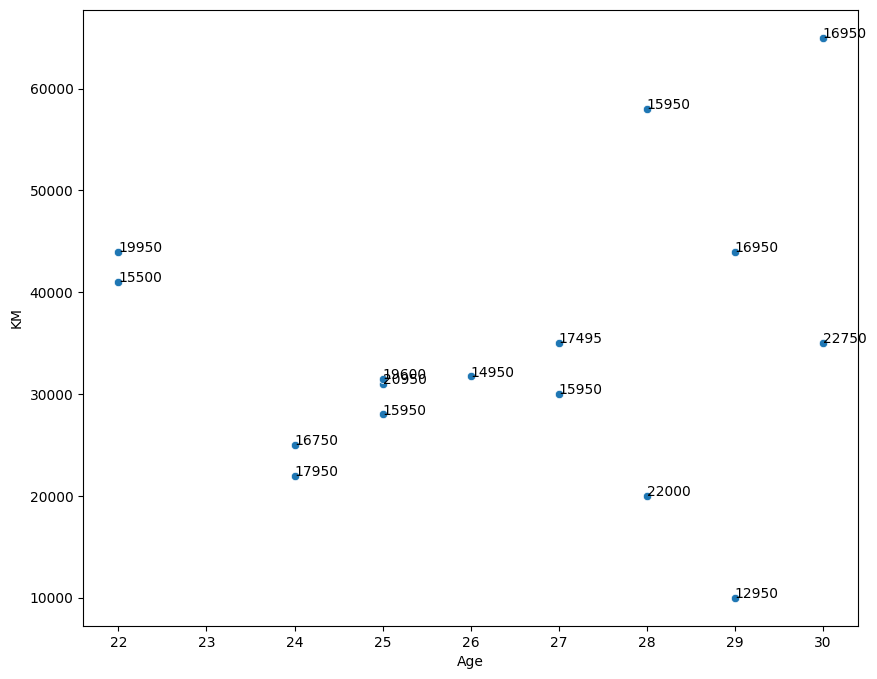

In [41]:
X = np.array([
    [22, 41000],
    [22, 44000],
    [24, 22000],
    [24, 25000],
    [25, 28000],
    [25, 31000],
    [25, 31500],
    [26, 31750],
    [27, 30000],
    [27, 35000],
    [28, 20000],
    [28, 58000],
    [29, 10000],
    [29, 44000],
    [30, 35000],
    [30, 65000],
])

Y = np.array([
    15500, 
    19950, 
    17950, 
    16750, 
    15950, 
    20950, 
    19600, 
    14950, 
    15950, 
    17495,
    22000,
    15950,
    12950,
    16950,
    22750,
    16950
])

fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x=X[:, 0], y=X[:, 1], ax=ax)
for i in range(X.shape[0]):
    ax.annotate(Y[i], (X[i, 0], X[i, 1]))
ax.set_xlabel("Age")
ax.set_ylabel("KM")

plt.show()

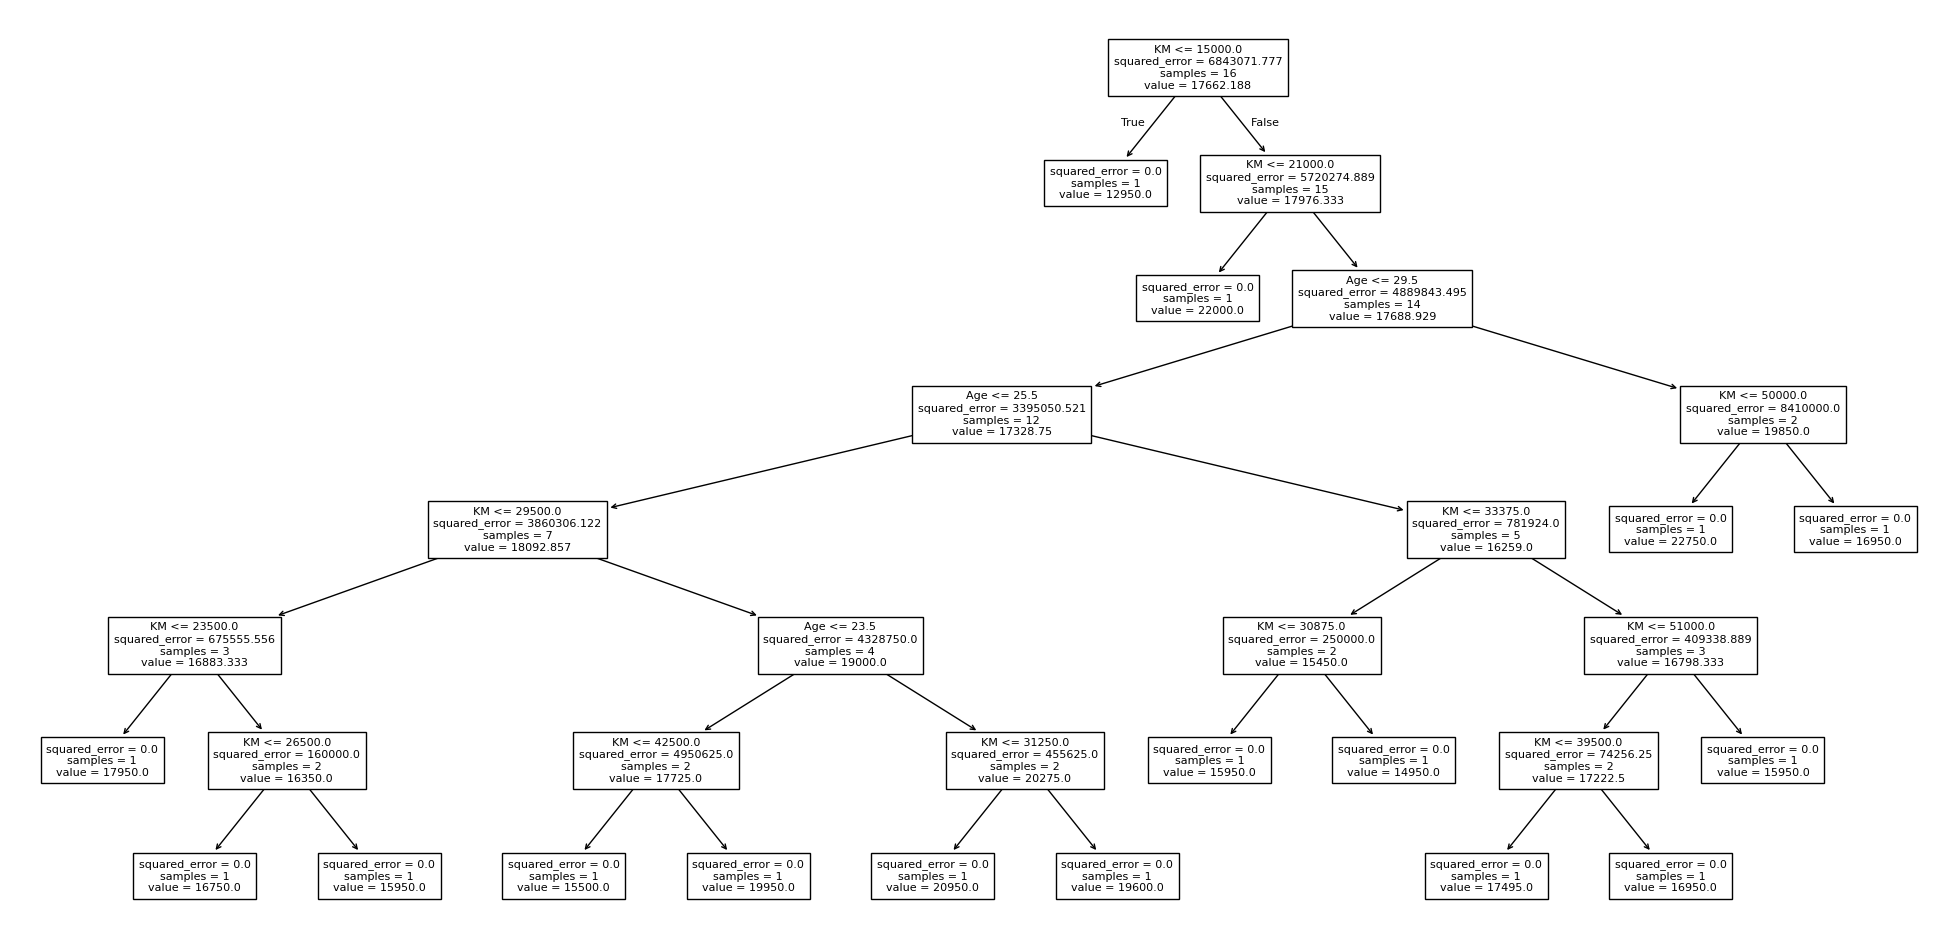

In [43]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

dt = DecisionTreeRegressor().fit(X, Y)
plt.figure(figsize=(25,12))
plot_tree(dt, fontsize=8, feature_names=['Age', 'KM'])
plt.show()

/home/jan/programming/python-dev/ZM001-2425-data-science/.venv/lib/python3.12/site-packages/sklearn/inspection/_plot/decision_boundary.py:191: UserWarning: The following kwargs were not used by contour: 'figsize'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


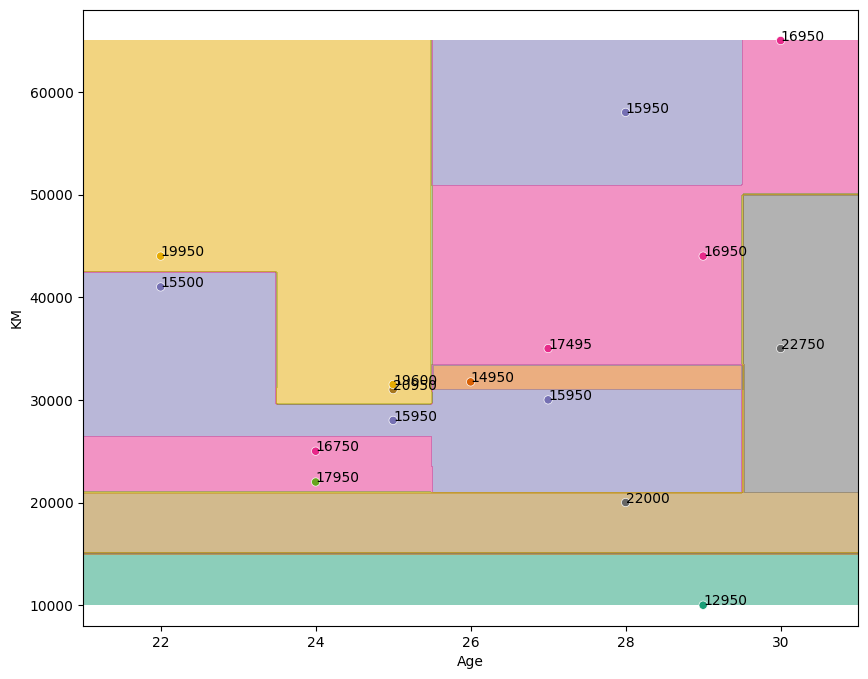

In [44]:
from sklearn.inspection import DecisionBoundaryDisplay

fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim((21, 31))
ax.set_ylim((8000, 68000))
DecisionBoundaryDisplay.from_estimator(
    dt, 
    X,
    xlabel='Age',
    ylabel='KM', 
    ax=ax, 
    grid_resolution=300,
    cmap='Dark2',
    alpha=0.5,
    figsize=(10,5)
)
sns.scatterplot(x=X[:, 0], y=X[:, 1], c=Y, cmap='Dark2', ax=ax)
for i in range(X.shape[0]):
    ax.annotate(Y[i], (X[i, 0], X[i, 1]))

A few notes:
- Every node in the decision tree is either a `decision node` or a  `leaf node`
- Every `decision node` $m$ conveys a test function, e.g., $f_m(X): X \leq w_0$, where $w_0$ is the threshold
- The line $w_{0}$ of $f_m(X)$ will always be **orthogonal** with respect to one of the axes
- Decision nodes always have two branches (true/false branch)

### Example decision split

Consider the split `KM <= 15000` 

In [45]:
split1 = X[:, 1] <= 15000
split1, split1 * Y

(array([False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False]),
 array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 12950,     0,     0,     0]))

The prediction of decision node $m$ with test function $f_m(X)$:
$$
    \overline{y}_m = \dfrac{\sum_i f_m(x_i) y_i}{\sum_i f_m(x_i)}
$$
In other words, $\overline{y}_m$ is the average (mean) of data points that passed the decision node test function

In [69]:
y_m = np.sum(split1 * Y)/np.sum(split1)
y_m

np.float64(12950.0)

Mean squared error (MSE) of decision node $m$:
$$
    E_m = \dfrac{1}{\sum_i f_m(x_i)} \sum_i (y_i - \overline{y}_m)^2 f_m(x_i)
$$

In [70]:
MSE = np.sum((Y - y_m)**2 * split1)/np.sum(split1)
MSE

np.float64(0.0)

The MSE is 0. Thus, this was a good decision split! But why is this split so good?

Consider a different split, e.g., `AGE <= 23`

In [71]:
split2 = X[:, 0] <= 23
split2, split2 * Y

(array([ True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]),
 array([15500, 19950,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]))

In [72]:
y_m = np.sum(split2 * Y)/np.sum(split2)
y_m

np.float64(17725.0)

In [73]:
MSE = np.sum((Y - y_m)**2 * split2)/np.sum(split2)
MSE

np.float64(4950625.0)

We can see what happens in a visual way

c:\Users\janba\python-dev\ZM001-2425-data-science\.venv\lib\site-packages\sklearn\inspection\_plot\decision_boundary.py:191: UserWarning: The following kwargs were not used by contour: 'figsize'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)


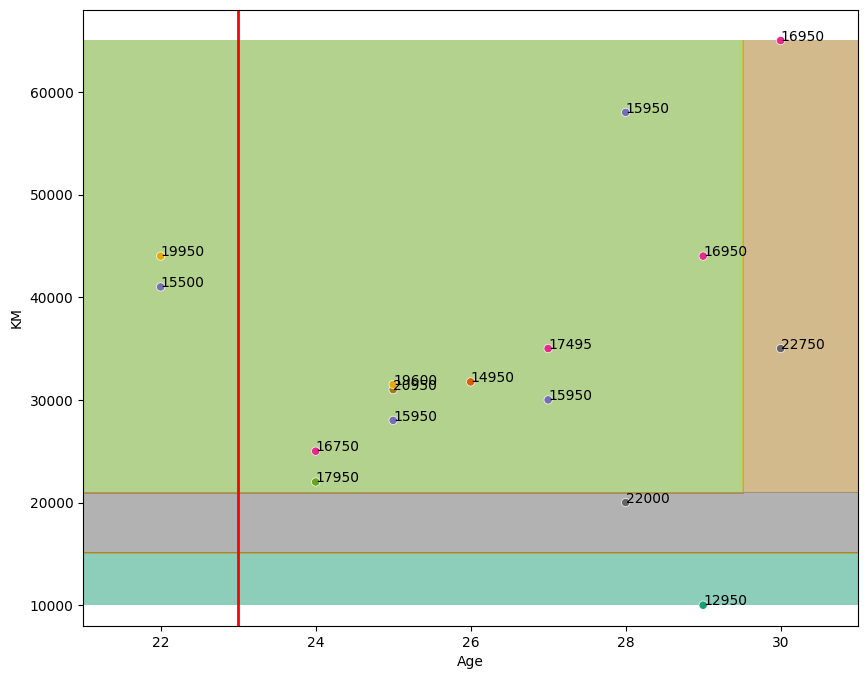

In [74]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlim((21, 31))
ax.set_ylim((8000, 68000))
DecisionBoundaryDisplay.from_estimator(
    dt, 
    X,
    xlabel='Age',
    ylabel='KM', 
    ax=ax, 
    grid_resolution=300,
    cmap='Dark2',
    alpha=0.5,
    figsize=(10,5)
)
sns.scatterplot(x=X[:, 0], y=X[:, 1], c=Y, cmap='Dark2', ax=ax)
for i in range(X.shape[0]):
    ax.annotate(Y[i], (X[i, 0], X[i, 1]))
ax.axvline(x=23, c='r', linewidth=2.0)

The idea is to automate this process by choosing a split based on the lowest MSE metric

In [46]:
unique_kms = np.unique(X[:, 0])
unique_ages = np.unique(X[:, 1])

# All possible split values + feature index 
thresholds = np.hstack([
    [unique_kms, [0]*unique_kms.shape[0]], 
    [unique_ages, [1]*unique_ages.shape[0]]
]).T

thresholds

array([[   22,     0],
       [   24,     0],
       [   25,     0],
       [   26,     0],
       [   27,     0],
       [   28,     0],
       [   29,     0],
       [   30,     0],
       [10000,     1],
       [20000,     1],
       [22000,     1],
       [25000,     1],
       [28000,     1],
       [30000,     1],
       [31000,     1],
       [31500,     1],
       [31750,     1],
       [35000,     1],
       [41000,     1],
       [44000,     1],
       [58000,     1],
       [65000,     1]])

In [47]:
best_MSE = np.inf
best_params = None

for w0, i in thresholds:
    split = X[:, i] <= w0                               # Test function
    y_m = np.sum(split * Y)/np.sum(split)               # Voorspelling van split
    MSE = np.sum((Y - y_m)**2 * split)/np.sum(split)    # Error van voorspelling 
    if MSE < best_MSE:                                  # optimalisatie
        best_MSE = MSE
        best_params = (w0, i)

best_MSE, best_params

(np.float64(0.0), (np.int64(10000), np.int64(1)))

Note: $w_0 = 10000$, whereas Sklearn's regression tree gave a value of 15000.
- Our implementation looks for the most specific hypothesis/prediction $S$
- In contrast, the most generic hypothesis/prediction $G$ leaves as much space between decision boundaries
- Sklearn takes a middle (low boundary + high boundary)/2
- e.g., $(10000+20000)/2 = 15000$
- This increases the margin of likelihood

![image info](./hypothesis.png)

## Random Forests

The idea behind **Bagging** (bootstrap aggregating):
- Generate $L$ training sets via bootstrapping
- Train $L$ base-learners (e.g., decision trees) based on $L$ overlapping training sets
- Take mean (in classification) or median (in regression) of the output of $L$ base-learners
- Base-learners need to be **unstable**, i.e., high variance and low bias
- Why is this advantageous? Mitigate high variance by aggregation
- **Goal**: create a diverse population of base-learners (each with high variance and low bias)
- Taking an average does not change the bias, but it leads to decreased variance 

((400, 2), (100, 2), (400,), (100,))

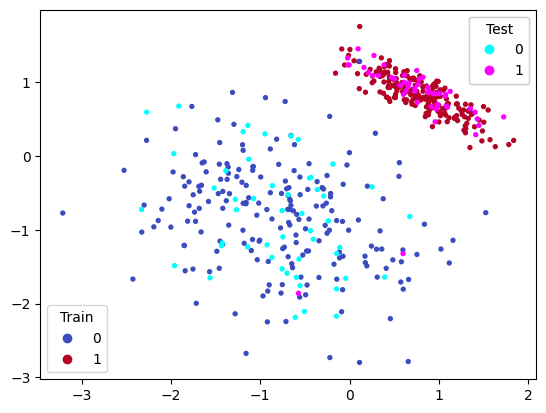

In [53]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# create synthetic dataset
X, Y = make_classification(
    n_samples=500, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=2,
    n_clusters_per_class=1,
    class_sep=1.2
)

# normalize so that mean is zero and unit variance
X = (X - X.mean(axis=0))/X.std(axis=0)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

# plot data
fig, ax = plt.subplots()

sc1 = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=8, cmap='coolwarm')
sc2 = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=8, cmap='cool')

leg1 = ax.legend(*sc1.legend_elements(), loc="lower left", title="Train")
leg2 = ax.legend(*sc2.legend_elements(), loc="upper right", title="Test")

ax.add_artist(leg1)
ax.add_artist(leg2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [54]:
# create cartesian product
xmin = X[:, 0].min(); xmax = X[:, 0].max()
ymin = X[:, 1].min(); ymax = X[:, 1].max()
xx, yy = np.meshgrid(
    np.linspace(xmin-.5, xmax+.5, 100),
    np.linspace(ymin-.5, ymax+.5, 100)
)
D = np.array([xx.ravel(), yy.ravel()]).T

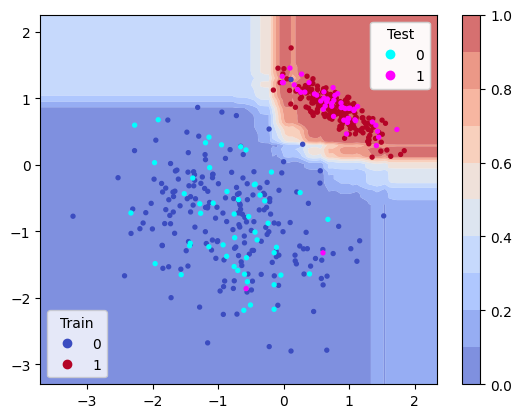

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)

# predict decision plane
y_hat_boundary = rf.predict_proba(D)[:, 1]

# visualize decision boundaries
fig, ax = plt.subplots()

contf = ax.contourf(xx, yy, y_hat_boundary.reshape(xx.shape), 10, cmap='coolwarm', alpha=0.7, antialiased=True)
colorbar = plt.colorbar(contf)

sc1 = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=8, cmap='coolwarm')
sc2 = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=8, cmap='cool')

leg1 = ax.legend(*sc1.legend_elements(), loc="lower left", title="Train")
leg2 = ax.legend(*sc2.legend_elements(), loc="upper right", title="Test")

ax.add_artist(leg1)
ax.add_artist(leg2)

plt.show()